This script predict IBD by SE of each cohort (cross-validation)

In [1]:
# This script predict IBD by SE of each cohort (cross-validation)
import os
import numpy as np
import pandas as pd
from itertools import chain
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

# load data
def get_cluster_data(data_dir):

    cluster_data = pd.DataFrame()

    for cohort_folder in os.listdir(data_dir):
        if not os.path.isdir(os.path.join(data_dir, cohort_folder)):
            continue
        if cohort_folder.startswith('IBD'):
            cohort_path = os.path.join(data_dir, cohort_folder, 'SE')

            crc_df = pd.read_csv(os.path.join(cohort_path, 'se_IBD.tsv'), sep='\t')
            crc_df['cohort'] = cohort_folder
            crc_df['label'] = 1
            crc_df = crc_df.rename(columns={'Unnamed: 0': 'sample'})

            health_df = pd.read_csv(os.path.join(cohort_path, 'se_Health.tsv'), sep='\t')
            health_df['cohort'] = cohort_folder
            health_df['label'] = 0
            health_df = health_df.rename(columns={'Unnamed: 0': 'sample'})
            
            cohort_data = pd.concat([crc_df, health_df], ignore_index=True)

            cluster_data = pd.concat([cluster_data, cohort_data], ignore_index=True)
    
    return cluster_data

In [2]:
data_dir = '../result/large_scale_cohort/IBD'
outdir = '../result/predict'
if not os.path.exists(outdir):
    os.makedirs(outdir)

cluster_df = get_cluster_data(data_dir)
p_files = []
for cohort in os.listdir(data_dir):
    if os.path.isdir(os.path.join(data_dir, cohort)):
        p_files.append(os.path.join(data_dir, cohort, 'SE', 'p_detail.tsv'))
# select significant different SE clusters
all_significant = []
for p_file in p_files:
    p_df = pd.read_csv(p_file, sep='\t')
    significant_clusters = p_df[p_df['p_adj'] < 0.05]['Unnamed: 0'].tolist()
    all_significant.append(significant_clusters)

significant_clusters = []
for cluster in set(chain(*all_significant)):
    if sum(cluster in s for s in all_significant) >= 2:
        significant_clusters.append(cluster)

print(f"Significant clusters: {significant_clusters}")

Significant clusters: ['cluster_S1-C17', 'cluster_S1-C16', 'cluster_S2-C4', 'cluster_S1-C22', 'cluster_S1-C15', 'cluster_S6-C3', 'cluster_S1-C5', 'root', 'cluster_S1-C10', 'cluster_S1-C4', 'cluster_S1-C9', 'cluster_S1-C1', 'supercluster_S3', 'cluster_S1-C20', 'supercluster_S2', 'cluster_S6-C1', 'cluster_S1-C3', 'supercluster_S6', 'cluster_S2-C5']


In [3]:
# cross-validation for each cohort
def run_cv_on_cohort(data_dir, cohort):

    p_file = os.path.join(data_dir, cohort, 'SE', 'p_detail.tsv')
    p_df = pd.read_csv(p_file, sep='\t')
    significant_clusters = p_df.loc[p_df['p_adj'] < 0.05, 'Unnamed: 0'].tolist()
    cluster_data = pd.DataFrame()
    for file_name in os.listdir(os.path.join(data_dir, cohort, 'SE')):
        if file_name.startswith(f'se_') and file_name.endswith('.tsv'):
            file_path = os.path.join(data_dir, cohort, 'SE', file_name)
            df = pd.read_csv(file_path, sep='\t')
            if file_name == f'se_Health.tsv':
                df['label'] = 0
            else:
                df['label'] = 1
            df = df.rename(columns={'Unnamed: 0': 'sample', 'cohort': 'cohort'})
            
            cluster_data = pd.concat([cluster_data, df], ignore_index=True)
    
    cohort_df = cluster_data
    
    auc_results = []
    mean_fpr = np.linspace(0, 1, 20)
    mean_tpr = np.zeros((20,))
    
    feature_importance_sum = {feature: 0 for feature in significant_clusters}

    for _ in range(20):
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        fold_auc_results = []
        fold_tprs = []
        for train_index, val_index in skf.split(cohort_df[significant_clusters], cohort_df['label']):
            train_df = cohort_df.iloc[train_index]
            val_df = cohort_df.iloc[val_index]
       
            X_train = train_df[significant_clusters]
            y_train = train_df['label']

            rf = RandomForestClassifier()
            rf.fit(X_train, y_train)

            X_val = val_df[significant_clusters]
            y_val = val_df['label']
            y_pred = rf.predict(X_val)
            val_auc = roc_auc_score(y_val, y_pred)
            fold_auc_results.append(val_auc)

            fpr, tpr, _ = roc_curve(y_val, y_pred)
            fold_tprs.append(np.interp(mean_fpr, fpr, tpr))
            fold_tprs[-1][0] = 0.0

            for feature, importance in zip(significant_clusters, rf.feature_importances_):
                feature_importance_sum[feature] += importance
        
        auc_results.append(np.mean(fold_auc_results))
    
    mean_auc = np.mean(auc_results)
    auc_std = np.std(auc_results)
    auc_95ci = (mean_auc - 1.96 * auc_std, mean_auc + 1.96 * auc_std)
    
    auc_95ci = (round(auc_95ci[0], 2), round(auc_95ci[1], 2))

    for fold_tpr in fold_tprs:
        mean_tpr += fold_tpr
    mean_tpr /= len(fold_tprs)
    mean_tpr[0] = 0.0
    mean_tpr[-1] = 1.0

    mean_feature_importance = {feature: importance / 200 for feature, importance in feature_importance_sum.items()}

    return significant_clusters, round(mean_auc, 2), auc_95ci, mean_fpr, mean_tpr, mean_feature_importance

IBD1,0.78(0.76~0.79)


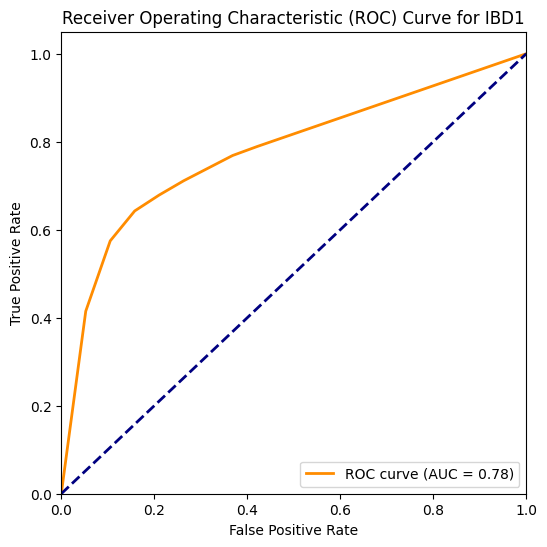

[('cluster_S1-C1', 0.12361760046622275), ('cluster_S2-C5', 0.10214857421905015), ('supercluster_S2', 0.0947212284353744), ('cluster_S1-C20', 0.06910487244035009), ('cluster_S1-C16', 0.05628481980328598), ('cluster_S1-C4', 0.05385091650211491), ('cluster_S1-C9', 0.05022639792040901), ('cluster_S1-C15', 0.04693406118272752), ('cluster_S6-C1', 0.04500010826343101), ('root', 0.04467860525306886), ('cluster_S1-C10', 0.04239225755016109), ('cluster_S1-C22', 0.0414750998407815), ('cluster_S1-C5', 0.04107550100052237), ('cluster_S1-C3', 0.03869135786215938), ('supercluster_S6', 0.03709744565141764), ('cluster_S1-C24', 0.028815979996620535), ('cluster_S1-C17', 0.027169037268613982), ('supercluster_S3', 0.026615683741409154), ('cluster_S2-C4', 0.01697783423938523), ('cluster_S1-C13', 0.013122618362894387)]


In [4]:
# IBD1
importance_df = pd.DataFrame()
cohort = 'IBD1'

significant_clusters, mean_auc, auc_95ci, mean_fpr, mean_tpr,mean_feature_importance = run_cv_on_cohort(data_dir, cohort)
print(f"{cohort},{mean_auc}({auc_95ci[0]}~{auc_95ci[1]})")

# plot ROC
plt.figure(figsize=(6, 6))
plt.plot(mean_fpr, mean_tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % mean_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve for {cohort}')
plt.legend(loc="lower right")

plt.savefig(os.path.join(outdir, '{}.self.roc_curve.svg'.format(cohort)), format='svg')
plt.show()

sorted_feature_importance = sorted(mean_feature_importance.items(), key=lambda x: x[1], reverse=True)

print(sorted_feature_importance)
for feature, importance in sorted_feature_importance:
    importance_df.loc[feature, 'IBD1'] = importance


IBD2,0.85(0.83~0.87)


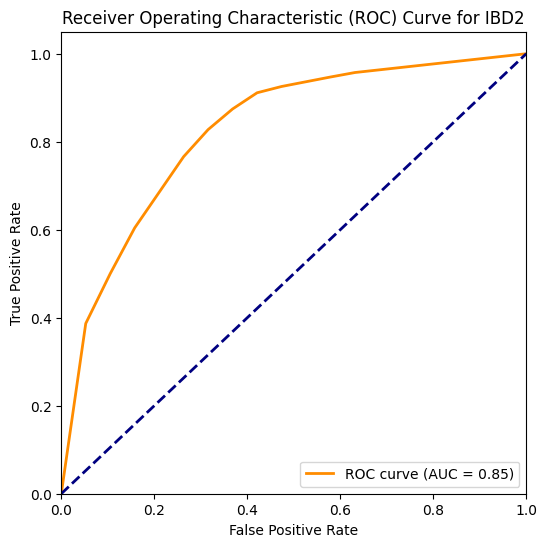

[('cluster_S1-C3', 0.15953104713201743), ('cluster_S1-C15', 0.14364803566468753), ('cluster_S1-C9', 0.12317179671969233), ('cluster_S1-C1', 0.08949941883794893), ('cluster_S1-C5', 0.08898737264367744), ('supercluster_S6', 0.08856208726201707), ('cluster_S1-C17', 0.07519136957494794), ('cluster_S1-C16', 0.04938125070090669), ('supercluster_S2', 0.04872539053299286), ('cluster_S6-C1', 0.038326508740450384), ('cluster_S1-C4', 0.027691548074138185), ('supercluster_S5', 0.026233976221393115), ('cluster_S6-C3', 0.017251007507899308), ('cluster_S2-C4', 0.013119503078629049), ('cluster_S5-C2', 0.007628257236750897), ('cluster_S1-C22', 0.003051430071850747)]


In [5]:
# IBD2

cohort = 'IBD2'

significant_clusters, mean_auc, auc_95ci, mean_fpr, mean_tpr,mean_feature_importance = run_cv_on_cohort(data_dir, cohort)
print(f"{cohort},{mean_auc}({auc_95ci[0]}~{auc_95ci[1]})")

# plot ROC
plt.figure(figsize=(6, 6))
plt.plot(mean_fpr, mean_tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % mean_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve for {cohort}')
plt.legend(loc="lower right")

plt.savefig(os.path.join(outdir, '{}.self.roc_curve.svg'.format(cohort)), format='svg')
plt.show()

sorted_feature_importance = sorted(mean_feature_importance.items(), key=lambda x: x[1], reverse=True)

print(sorted_feature_importance)
for feature, importance in sorted_feature_importance:
    importance_df.loc[feature, 'IBD2'] = importance

IBD3,0.83(0.82~0.85)


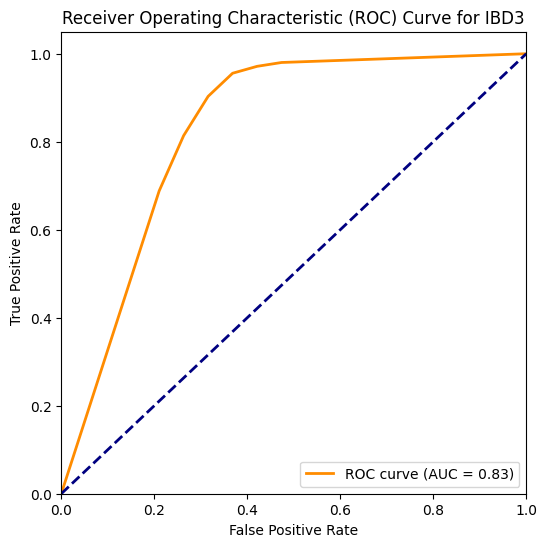

[('cluster_S1-C15', 0.13620482845049178), ('supercluster_S1', 0.0983143859973706), ('cluster_S1-C3', 0.09629226840364132), ('cluster_S1-C8', 0.07899814828106985), ('cluster_S1-C10', 0.07832325387708561), ('cluster_S1-C16', 0.07642567789735512), ('cluster_S1-C20', 0.07496451491863974), ('root', 0.07173336616861944), ('cluster_S1-C2', 0.06983360558203425), ('cluster_S1-C1', 0.06878397155963292), ('supercluster_S3', 0.06030615087895986), ('cluster_S6-C3', 0.04295084888500472), ('cluster_S2-C5', 0.03807882168015297), ('cluster_S3-C1', 0.00879015741994174)]


In [6]:
# IBD3
cohort = 'IBD3'

significant_clusters, mean_auc, auc_95ci, mean_fpr, mean_tpr,mean_feature_importance = run_cv_on_cohort(data_dir, cohort)
print(f"{cohort},{mean_auc}({auc_95ci[0]}~{auc_95ci[1]})")

# plot ROC
plt.figure(figsize=(6, 6))
plt.plot(mean_fpr, mean_tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % mean_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve for {cohort}')
plt.legend(loc="lower right")

plt.savefig(os.path.join(outdir, '{}.self.roc_curve.svg'.format(cohort)), format='svg')
plt.show()

sorted_feature_importance = sorted(mean_feature_importance.items(), key=lambda x: x[1], reverse=True)

print(sorted_feature_importance)
for feature, importance in sorted_feature_importance:
    importance_df.loc[feature, 'IBD3'] = importance

In [7]:
importance_df.to_csv(os.path.join(outdir, 'feature_importance_IBD_CV.tsv'), sep='\t')